In [1]:
# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd sjk012/datasets/
!bash get_datasets.sh
%cd ../../

!pip install numpy matplotlib threadpoolctl imageio cython

# Download and install the OpenBLAS and BLIS libraries
%mkdir -p sjk012/software
%cd sjk012/software
%rm -rf blis
!git clone https://github.com/flame/blis.git 
%cd blis/
!./configure --prefix=${HOME}/install/blis --enable-cblas --enable-threading=openmp auto &> /dev/null
!make -j4 install 
%cd ..
%rm -rf OpenBLAS
!git clone https://github.com/OpenMathLib/OpenBLAS.git
%cd OpenBLAS
!make -j4 &> /dev/null
!make PREFIX=${HOME}/install/openblas install
%cd ../../../
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:${HOME}/install/blis/lib:${HOME}/install/openblas/lib

/home/pabloju/HPML/assignment1/sjk012/datasets
/home/pabloju/HPML/assignment1
/home/pabloju/HPML/assignment1/sjk012/software
Cloning into 'blis'...
remote: Enumerating objects: 52580, done.
remote: Counting objects: 100% (13423/13423), done.
remote: Compressing objects: 100% (1309/1309), done.
remote: Total 52580 (delta 12484), reused 12489 (delta 12110), pack-reused 39157
Receiving objects: 100% (52580/52580), 48.76 MiB | 7.10 MiB/s, done.
Resolving deltas: 100% (42709/42709), done.
/home/pabloju/HPML/assignment1/sjk012/software/blis
Generating monolithic blis.hGenerating monolithic cblas.hInstalling blis.h helper header into /home/pabloju/install/blis/include/
Installing cblas.h helper header into /home/pabloju/install/blis/include/
Installing config.mk common.mk into /home/pabloju/install/blis/share/blis/
Installing blis.pc into /home/pabloju/install/blis/share/pkgconfig/
Installing config/haswell/make_defs.mk into /home/pabloju/install/blis/share/blis/config/haswell
...............

# Fully-Connected Neural Nets
In this first assignment we will implement and parallelise fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from sjk012.data_utils import get_CIFAR10_data
from sjk012.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from sjk012.solver import Solver
from sjk012.operations import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()

for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

data['X_train']= data['X_train'].reshape(data['X_train'].shape[0], np.prod(data['X_train'].shape[1:])).astype(np.float32)
data['X_val']  = data['X_val'  ].reshape(data['X_val'  ].shape[0], np.prod(data['X_val'  ].shape[1:])).astype(np.float32)
data['X_test'] = data['X_test' ].reshape(data['X_test' ].shape[0], np.prod(data['X_test' ].shape[1:])).astype(np.float32)

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Naive matmul operator:
Open the file `sjk012/operations.py` and implement the `matmul_naive` function.

Once you are done you can test your implementation by running the following:

In [7]:
a_shape = (3, 5)
b_shape = (5, 4)
c_shape = (3, 4)

a = np.linspace(-0.1, 0.5, num=np.prod(a_shape), dtype=np.float32).reshape(a_shape)
b = np.linspace(-0.2, 0.3, num=np.prod(b_shape), dtype=np.float32).reshape(b_shape)
c = np.linspace(-0.3, 0.1, num=np.prod(c_shape), dtype=np.float32).reshape(c_shape)

c_out_naive = matmul_naive(a, b, c)

correct_c = np.array([[-0.2556391,  -0.22115516, -0.18667122, -0.15218729],
                      [-0.09890636, -0.03622693,  0.02645249,  0.08913192],
                      [ 0.05782638,  0.1487013,   0.23957621,  0.33045113]])

# Compare your output with ours. The error should be around e-7 or less.
print('Testing matmul_naive function:')
print('difference: ', rel_error(c_out_naive, correct_c))

Testing matmul_naive function:
difference:  2.6648552970039633e-07


# Numpy matmul operator:
Open the file `sjk012/operations.py` and implement the `matmul_numpy` function.

Once you are done you can test your implementation running the following code:

In [8]:
c = np.linspace(-0.3, 0.1, num=np.prod(c_shape), dtype=np.float32).reshape(c_shape)

c_out_np = matmul_numpy(a, b, c)

# Compare your output with ours. The error should be around e-7 or less.
print('Testing matmul_numpy function:')
print('difference: ', rel_error(c_out_np, correct_c))

Testing matmul_numpy function:
difference:  2.6648552970039633e-07


# cblas_gemm:
Open the file `sjk012/operations.py` and implement the `matmul_cblas` function in order to call to `cblas_sgemm` BLAS3 function. See: https://netlib.org/lapack/explore-html/de/da0/cblas_8h_a1446cddceb275e7cd299157a5d61d5e4.html

Here's a simple example demonstrating how to call an external function using ctypes:

```python
import ctypes

# Load the library containing the external function
libc = ctypes.CDLL('/path/to/your/library.so')  # Replace '/path/to/your/library.so' with the path to your library

# Define the argument types and return type of the external function
libc.my_external_function.argtypes = [ctypes.c_int, ctypes.c_int]
libc.my_external_function.restype = ctypes.c_int

# Call the external function
result = libc.my_external_function(3, 4)
```

Once you are done, add the location of the OpenBLAS and BLIS libraries to the `LD_LIBRARY_PATH` environment variable.

In [4]:
import os
os.environ['LD_LIBRARY_PATH'] = os.environ['LD_LIBRARY_PATH'] + ":" + os.environ['HOME'] + "/install/blis/lib:" + os.environ['HOME'] + "/install/openblas/lib"

Afterwards, you can test your implementation using OpenBLAS running the code below:

In [9]:
c = np.linspace(-0.3, 0.1, num=np.prod(c_shape), dtype=np.float32).reshape(c_shape)
openblas = load_library("openblas")

c_out_cblas = matmul_cblas(openblas, a, b, c)

# Compare your output with ours. The error should be around e-7 or less.
print('Testing matmul_cblas function:')
print('difference: ', rel_error(c_out_cblas, correct_c))

Testing matmul_cblas function:
difference:  2.6648552970039633e-07


Try the same as before but using the BLIS library: 

In [10]:
c = np.linspace(-0.3, 0.1, num=np.prod(c_shape), dtype=np.float32).reshape(c_shape)
blis = load_library("blis")

c_out_cblas = matmul_cblas(blis, a, b, c)

# Compare your output with ours. The error should be around e-7 or less.
print('Testing matmul_cblas function:')
print('difference: ', rel_error(c_out_cblas, correct_c))

Testing matmul_cblas function:
difference:  2.6648552970039633e-07


# Tiled GEMM multiplication:

In this task, you will implement tiling for the inner loops of the GEMM operation. The idea is to divide the matrices into smaller tiles and then perform the multiplication on these tiles. The following pseudo-code and figure illustrate the concept of tiling for the inner loops of GEMM. You need to also parallelize the outer loop using OpenMP.

![Tiled GEMM](sjk012/img/tiled_gemm.png) 

Open the file `sjk012/tiled_gemm/tiled_gemm.pyx` and implement the `matmul_tiled_cython_inner`.

```
function matmul_tiled_cython_inner(A, B, C, M, N, K, blockSize):
    for m from 0 to M step blockSize:
        for n from 0 to N step blockSize:
            for k from 0 to K step blockSize:

                // Calculate upper bounds for each block
                mUpper = min(m + blockSize, M)
                nUpper = min(n + blockSize, N)
                kUpper = min(k + blockSize, K)

                for i from m to mUpper:
                    for j from n to nUpper:
                        temp = 0
                        for l from k to kUpper:
                            temp += A[i][l] * B[l][j]
                        C[i][j] += temp
end function
```

Use the `prange` function from Cython to parallelize the first loop via OpenMP. See https://cython.readthedocs.io/en/latest/src/userguide/parallelism.html

Open the file `sjk012/operations.py` and implement the `matmul_tiled` function in order to call to `tiled_gemm` function that you have just implemented. 

Afterwards, you can test your implementation running the code below. Note that the code will automatically compile the Cython module and will store it in `~/.pyxbld`. If you want to compile it manually, run `python
setup.py build_ext --inplace`.

In [11]:
%reload_ext autoreload

c = np.linspace(-0.3, 0.1, num=np.prod(c_shape), dtype=np.float32).reshape(c_shape)

import pyximport
pyximport.install(reload_support=True, pyimport=True)
from sjk012.tiled_gemm.tiled_gemm import matmul_tiled_cython

c_out_tiled = matmul_tiled_cython(a, b, c, 32)
# Compare your output with ours. The error should be around e-7 or less.
print('Testing matmul_tiled function:')
print('difference: ', rel_error(c_out_tiled, correct_c))

Testing matmul_tiled function:
difference:  2.6648552970039633e-07


# Tiled gemm block size performance evaluation:

Now that we have implemented the tiled GEMM, we have to evaluate the optimal block size for the target machine. Try using different number of threads to see what could be the best option. 

*You can write here your conclusions:*

From the results, we can observe that the execution time decreases as the tile size increases from 4 to 16. This is likely due to the fact that larger tiles can make better use of the CPU cache, reducing the need for slow memory accesses.

However, beyond a tile size of 16, the execution time starts to increase again. This could be because the tiles are becoming too large to fit into the CPU cache, causing an increase in cache misses and therefore slower memory accesses. In this way, the optimal block size for this particular machine and problem size appears to be 16, as this is the point at which the execution time is the lowest.

In [12]:
from sjk012.operations import *
from sjk012.fc_net import *
from threadpoolctl import threadpool_limits
import numpy as np
import time

# Create numpy arrays for matrices a, b, and c
m, n, k = 2048, 2048, 2048

a = np.random.rand(m, k).astype(np.float32)
b = np.random.rand(k, n).astype(np.float32)

with threadpool_limits(limits=8):
    tile_sizes = [4, 8, 16, 32, 64, 128, 256, 512]

    ###########################################################################
    # TODO: Call the matmul_tiled_cython passing above defined tile_sizes     #
    # and obtain the execution time for each size                             #
    ###########################################################################
    
    execution_times = []

    for size in tile_sizes:
        start_time = time.time()
        c_out_tiled = matmul_tiled_cython(a, b, c, size)
        end_time = time.time()
        execution_time = end_time - start_time
        execution_times.append(execution_time)
        print('Tile size: %d, execution time: %f' % (size, execution_time))
        
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

Tile size: 4, execution time: 9.574808
Tile size: 8, execution time: 5.427187
Tile size: 16, execution time: 3.586460
Tile size: 32, execution time: 4.136194
Tile size: 64, execution time: 5.083670
Tile size: 128, execution time: 5.380460
Tile size: 256, execution time: 15.881750
Tile size: 512, execution time: 17.123160


# Parallel performance evaluation

Now, evaluate the performance of the different versions using the corresponding parallel versions.

First, set the corresponding location of `libgomp.so` to the `LD_LIBRARY_PATH` environment variable (you would probably need to adjust the path where `libgomp.so` is located in your platform):

In [5]:
import os
os.environ['LD_LIBRARY_PATH'] = os.environ['LD_LIBRARY_PATH'] + ":" + "/usr/lib/gcc/x86_64-linux-gnu/9/"

Test the code running the matmul implementations in parallel using OpenMP threads.

In [12]:
from threadpoolctl import threadpool_limits
from pprint import pprint

# Define matrix sizes
sizes = [2**i for i in range(4, 12)]

# Number of repetitions
repetitions = 1
tile_size = 16

thread_range = [1, 2, 4, 8, 16, 24]

# Initialize arrays to store execution times
numpy_times = np.zeros((len(sizes), len(thread_range)))
openblas_times = np.zeros((len(sizes), len(thread_range)))
blis_times = np.zeros((len(sizes), len(thread_range)))
tiled_times = np.zeros((len(sizes), len(thread_range)))

from threadpoolctl import threadpool_limits
from pprint import pprint

# Define matrix sizes
sizes = [2**i for i in range(4, 12)]

# Number of repetitions
repetitions = 1
tile_size = 16

thread_range = [1, 2, 4, 8, 16, 24]

# Initialize arrays to store execution times
numpy_times = np.zeros((len(sizes), len(thread_range)))
openblas_times = np.zeros((len(sizes), len(thread_range)))
blis_times = np.zeros((len(sizes), len(thread_range)))
tiled_times = np.zeros((len(sizes), len(thread_range)))

for num_threads, n_threads in enumerate(thread_range):
    with threadpool_limits(limits=n_threads):
        
        # Measure performance for each size
        for idx, size in enumerate(sizes):
            print(f"Matrix size: {size} x {size}, Threads: {n_threads}")

            # Initialize arrays to store execution times for current size
            numpy_times_size = []
            openblas_times_size = []
            blis_times_size = []
            tiled_times_size = []

            for _ in range(repetitions):
                ###########################################################################
                # TODO: Call the corresponding versions of the matmul and append the times #
                # to the previously created vectors                                       #
                ###########################################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****                  
                # Generate random matrices
                a = np.random.rand(size, size).astype(np.float32)
                b = np.random.rand(size, size).astype(np.float32)
                c = np.random.rand(size, size).astype(np.float32)

                # Measure performance of numpy implementation
                start_time = time.time()
                c_out_np = matmul_numpy(a, b, c)
                end_time = time.time()
                numpy_times_size.append(end_time - start_time)
                 
                # Measure performance of tiled implementation
                start_time = time.time()
                c_out_tiled = matmul_tiled_cython(a, b, c, tile_size)
                end_time = time.time()
                tiled_times_size.append(end_time - start_time)

                # Measure performance of cblas implementation with OpenBLAS
                start_time = time.time()
                c_out_cblas = matmul_cblas(openblas, a, b, c)
                end_time = time.time()
                openblas_times_size.append(end_time - start_time)

                # Measure performance of cblas implementation with BLIS
                start_time = time.time()
                c_out_cblas = matmul_cblas(blis, a, b, c)
                end_time = time.time()
                blis_times_size.append(end_time - start_time)

                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                ###########################################################################
                #                             END OF YOUR CODE                            #
                ###########################################################################            

            # Compute average execution times for current size and number of threads
            numpy_times[idx, num_threads] = np.mean(numpy_times_size)
            openblas_times[idx, num_threads] = np.mean(openblas_times_size)
            blis_times[idx, num_threads] = np.mean(blis_times_size)
            tiled_times[idx, num_threads] = np.mean(tiled_times_size)


Matrix size: 16 x 16, Threads: 1
Matrix size: 32 x 32, Threads: 1
Matrix size: 64 x 64, Threads: 1
Matrix size: 128 x 128, Threads: 1
Matrix size: 256 x 256, Threads: 1
Matrix size: 512 x 512, Threads: 1
Matrix size: 1024 x 1024, Threads: 1
Matrix size: 2048 x 2048, Threads: 1
Matrix size: 16 x 16, Threads: 2
Matrix size: 32 x 32, Threads: 2
Matrix size: 64 x 64, Threads: 2
Matrix size: 128 x 128, Threads: 2
Matrix size: 256 x 256, Threads: 2
Matrix size: 512 x 512, Threads: 2
Matrix size: 1024 x 1024, Threads: 2
Matrix size: 2048 x 2048, Threads: 2
Matrix size: 16 x 16, Threads: 4
Matrix size: 32 x 32, Threads: 4
Matrix size: 64 x 64, Threads: 4
Matrix size: 128 x 128, Threads: 4
Matrix size: 256 x 256, Threads: 4
Matrix size: 512 x 512, Threads: 4
Matrix size: 1024 x 1024, Threads: 4
Matrix size: 2048 x 2048, Threads: 4
Matrix size: 16 x 16, Threads: 8
Matrix size: 32 x 32, Threads: 8
Matrix size: 64 x 64, Threads: 8
Matrix size: 128 x 128, Threads: 8
Matrix size: 256 x 256, Threads:

Plot the execution times and observe the times of each matmul version running with different number of threads. 

Which version scales better with regards to the number of threads and matrix size? What is the most efficient?

*Write here your observations:*

Numpy times: Remains constant as for the maximum matrix size tested, but goes down in performance when threads goes up for smaller matrixes.

OpenBLAS times: So similar to Numpy. With this approach the effect on smaller matrix sizes seen in numpy appears later (4 threads vs 2 in Numpy) but its execution times for smaller matrixes when number of threads are increased are even bigger than Numpy ones.

BLIS times: The time taken increases regularly with matrix size, but it gives the best results until 4 threads. When threads goes to 16 the execution time start to be a plateau, being more visualy when 24 threads are used.

Tiled times: The time taken increases regularly with matrix size and it is not affected by the number of threads used.

In general terms, the versions that scale better with the number of threads are Numpy for bigger matrixes and OpenBLAS for smaller ones, and the most efficient one would be probably the BLIS one with 2 and 4 threads, where it has good times for all sizes.

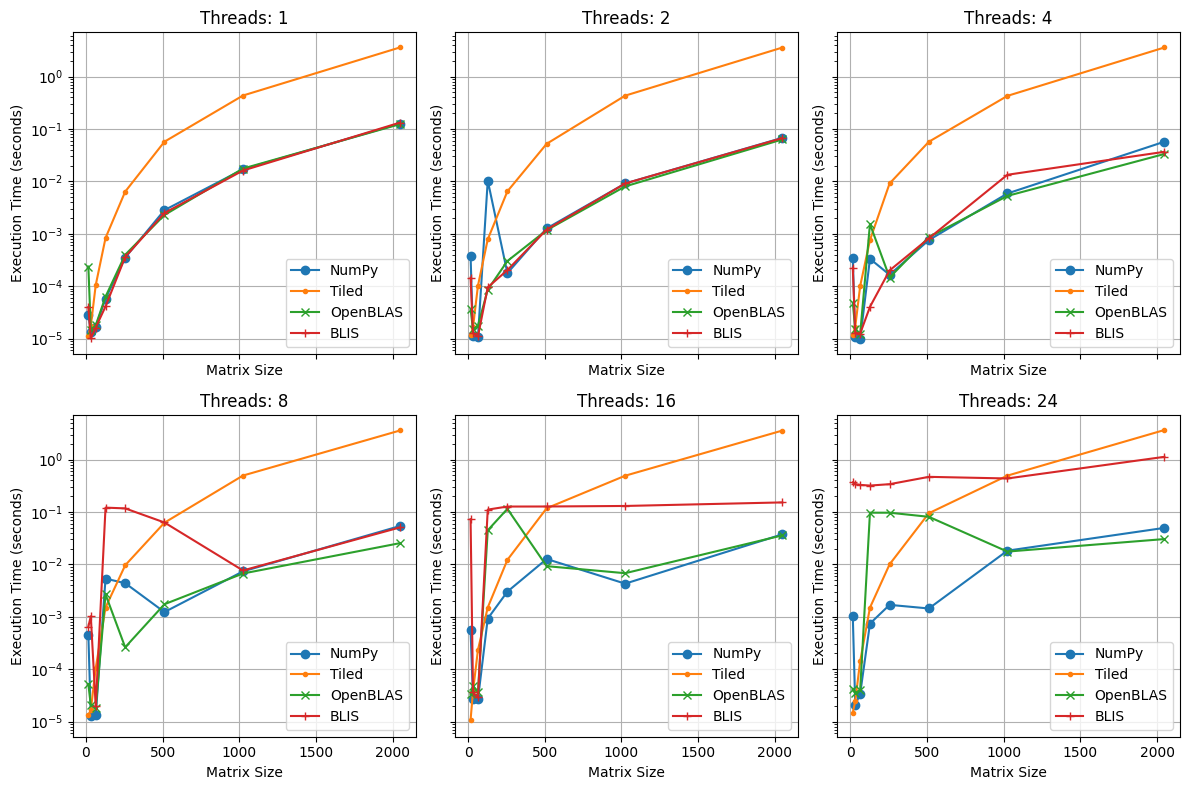

In [13]:
# Plotting subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

for i, n_threads in enumerate([1, 2, 4, 8, 16, 24]):
    row = i // 3
    col = i % 3
    axs[row, col].plot(sizes, numpy_times[:, i], marker='o', label=f'NumPy')
    axs[row, col].plot(sizes, tiled_times[:, i], marker='.', label=f'Tiled')
    axs[row, col].plot(sizes, openblas_times[:, i], marker='x', label=f'OpenBLAS')
    axs[row, col].plot(sizes, blis_times[:, i], marker='+', label=f'BLIS')
    axs[row, col].set_title(f'Threads: {n_threads}')
    axs[row, col].set_xlabel('Matrix Size')
    axs[row, col].set_ylabel('Execution Time (seconds)')
    axs[row, col].legend()
    axs[row, col].set_yscale("log")
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

Plot now the speedups of the different matmul versions and write your observations.

Observations:

As said before, tiled remain constant, BLIS is good with few threads but goes down when increasing them, and the ones that still have a good performance even with more threads are Numpy and OpenBLAS versions.

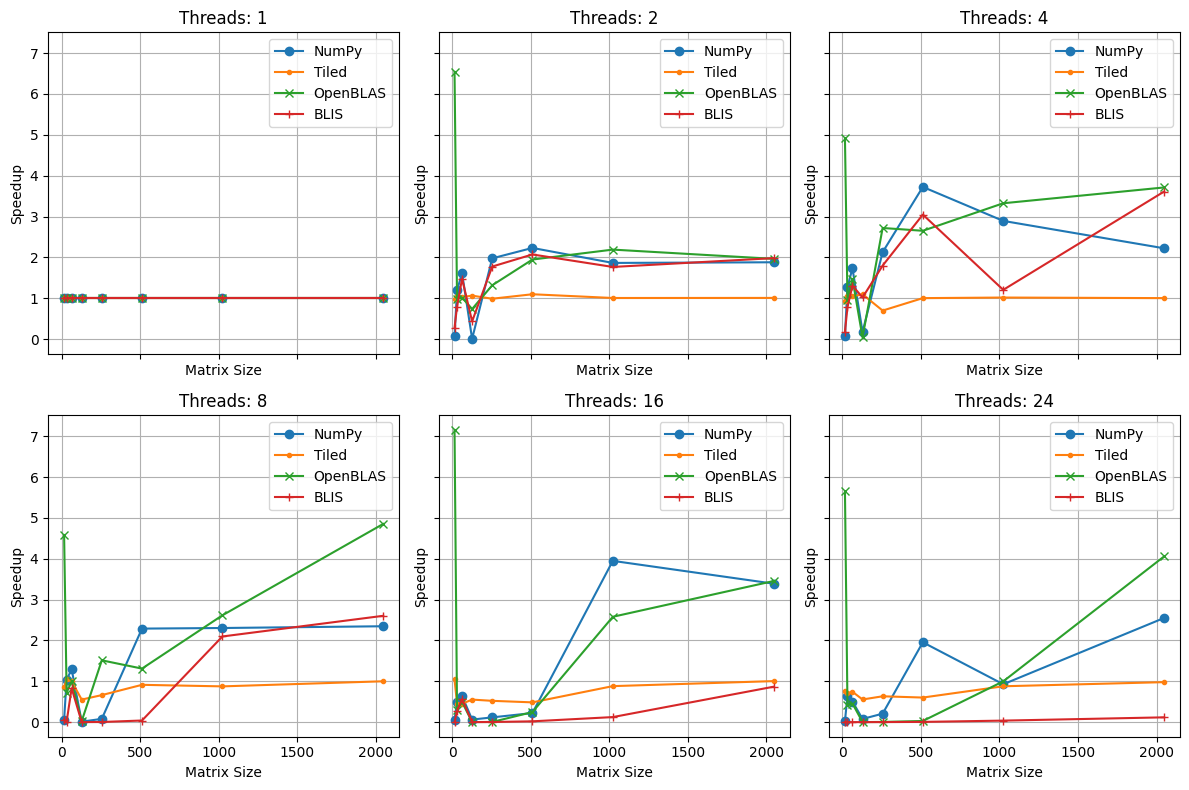

In [16]:
# Plotting subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

for i, n_threads in enumerate([1, 2, 4, 8, 16, 24]):
    row = i // 3
    col = i % 3
    axs[row, col].plot(sizes, numpy_times[:, 0] / numpy_times[:, i], marker='o', label=f'NumPy')
    axs[row, col].plot(sizes, tiled_times[:, 0] / tiled_times[:, i], marker='.', label=f'Tiled')
    axs[row, col].plot(sizes, openblas_times[:, 0] / openblas_times[:, i], marker='x', label=f'OpenBLAS')
    axs[row, col].plot(sizes, blis_times[:, 0] / blis_times[:, i], marker='+', label=f'BLIS')
    axs[row, col].set_title(f'Threads: {n_threads}')
    axs[row, col].set_xlabel('Matrix Size')
    axs[row, col].set_ylabel('Speedup')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()


# Fully-Connected Layer: Forward Pass

To implement the forward pass for the fully-connected layer, open the file `sjk012/layers.py` and implement the `fc_forward` function. This function utilizes matrix multiplication (`matmul`) to perform the forward pass efficiently.

### Forward Pass Formula:

Given input data \($X$\), weights \($W$\), and biases \($b$\), the forward pass for the fully-connected layer can be defined as:

$$\text{out} = X \times W + b$$

### Implementation:

1. **Matrix Multiplication**: Perform matrix multiplication between input data \($X$\) and weights \($W$\).
2. **Add Bias**: Add the biases \($b$\) to the result of the matrix multiplication.

Once you complete the implementation of the `fc_forward` function, you can test its correctness by running the provided code.

In [18]:
# Test the fc_forward function
from sjk012.layers import fc_forward

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)
x = np.linspace(-0.1, 0.5, num=input_size, dtype=np.float32).reshape(num_inputs, np.prod(input_shape))
w = np.linspace(-0.2, 0.3, num=weight_size, dtype=np.float32).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim, dtype=np.float32)

out, _ = fc_forward(x, w, b)

correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing fc_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing fc_forward function:
difference:  5.2886153808560255e-08


# Fully-Connected Layer: Backward Pass

To implement the backward pass for the fully-connected layer, you need to open the file `sjk012/layers.py` and implement the `fc_backward` function.

### Backward Pass Formula:

The backward pass for the fully-connected layer involves computing gradients with respect to the input data \($X$\), weights \($W$\), and biases \($b$\). 

The gradients with respect to \($X$\), \($W$\), and \($b$\) can be computed using the chain rule and are given by:

$$\nabla X = \nabla Y \times W^T$$

$$\nabla W = X^T \times \nabla Y$$

$$\nabla b = \text{sum}(\nabla Y, axis=0)$$

Where \($L$\) is the loss function and \($\nabla Y$\) is the gradient of the loss with respect to the output of the fully-connected layer.

### Implementation:

1. **Gradient with Respect to Input**: Perform matrix multiplication between upstream gradient \($\nabla Y$\) and the transposed weights weights \($W^T$\).
2. **Gradient with Respect to Weights**: Perform matrix multiplication between transposed inputs \($X^T$\) and the upstream gradient \($\nabla Y$\).
3. **Gradient with Respect to Biases**: Compute the gradient with respect to biases \($\nabla b$\) using the formula above.

Once you complete the implementation of the `fc_backward` function, you can test its correctness using numeric gradient checking.


In [19]:
# Test the fc_backward function
from sjk012.layers import fc_backward

np.random.seed(12)
x = np.random.randn(10, 2, 3).astype(np.float32).reshape(10, 2*3)
w = np.random.randn(6, 5).astype(np.float32)
b = np.random.randn(5).astype(np.float32)
dy = np.random.randn(10, 5).astype(np.float32)

dx_num = eval_numerical_gradient_array(lambda x: fc_forward(x, w, b)[0], x, dy, h=1e-1)
dw_num = eval_numerical_gradient_array(lambda w: fc_forward(x, w, b)[0], w, dy, h=1e-1)
db_num = eval_numerical_gradient_array(lambda b: fc_forward(x, w, b)[0], b, dy, h=1e-1)

_, cache = fc_forward(x, w, b)
dx, dw, db = fc_backward(dy, cache)

# The error should be around e-5 or less
print('Testing fc_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing fc_backward function:
dx error:  2.38993e-05
dw error:  1.8927357e-06
db error:  2.3024736e-06


# ReLU Activation: Forward Pass

To implement the forward pass for the ReLU activation function, you need to open the file `sjk012/layers.py` and implement the `relu_forward_numpy` function.

### Forward Pass Formula:

The forward pass for the ReLU activation function applies an element-wise operation to the input data \($X$\) and is given by:

$$Y = \text{max}(0, X)$$
$$\text{mask} = X > 0$$

### Implementation:

1. **Element-wise Operation**: Apply the ReLU function element-wise to the input data \($X$\), replacing negative values with zeros.
2. **Mask Calculation**: Calculate the mask $ \text{mask} = X > 0 $, which will be used for the backward pass to compute gradients.

Once you complete the implementation of the `relu_forward_numpy` function, you can test its correctness using the provided code.

In [21]:
# Test the relu_forward function
from sjk012.layers import relu_forward_numpy

x = np.linspace(-0.5, 0.5, num=12, dtype=np.float32).reshape(3, 4)

out, _ = relu_forward_numpy(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  3.5098836564329345e-08


### ReLU Activation: Forward Pass with Cython:

1. **Element-wise Operation**: Apply the ReLU function element-wise to the input data \( X \), replacing negative values with zeros.
2. **Parallelization**: Utilize OpenMP parallelization to efficiently compute the ReLU operation across multiple threads.

Once you complete the implementation of the forward pass in `relu_fwd.pyx`, you need to compile the Cython module containing this function. You can compile it by executing the provided code or by running `python setup.py build_ext --inplace` in the previous directory.


In [9]:
%reload_ext autoreload
# Test the relu_cython function
from sjk012.layers import relu_forward_cython

import pyximport
pyximport.install(reload_support=True, pyimport=True)
from sjk012.relu_fwd.relu_fwd import relu_fwd_cython

x = np.linspace(-0.5, 0.5, num=12, dtype=np.float32).reshape(3, 4)

out, _ = relu_forward_cython(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])


# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  3.5098836564329345e-08


# ReLU Parallel Performance Evaluation

To evaluate the performance of different versions of ReLU activation function using parallelization, follow these steps:

1. **Set Library Location**: Add the location of `libgomp.so` to the `LD_LIBRARY_PATH` environment variable. This ensures that the OpenMP library is accessible during execution.

2. **Performance Evaluation**: Compare the performance of different versions of ReLU activation function with and without parallelization. Measure execution times for each version and observe the impact of parallelization on speedup.

Below is a sample code snippet demonstrating how to set the library location and perform performance evaluation:


In [6]:
os.environ['LD_LIBRARY_PATH'] = os.environ['LD_LIBRARY_PATH'] + ":" + "/usr/lib/gcc/x86_64-linux-gnu/9/"

In [12]:
from threadpoolctl import threadpool_limits
from pprint import pprint

# Define matrix sizes
sizes = [2**i for i in range(4, 14)]

# Number of repetitions
repetitions = 10

thread_range = [1, 2, 4, 8, 16, 24]

# Initialize arrays to store execution times
relu_numpy_times = np.zeros((len(sizes), len(thread_range)))
relu_cython_times = np.zeros((len(sizes), len(thread_range)))

for num_threads, n_threads in enumerate(thread_range):
    with threadpool_limits(limits=n_threads):
        
        # Measure performance for each size
        for idx, size in enumerate(sizes):
            print(f"Matrix size: {size} x {size}, Threads: {n_threads}")

            # Initialize arrays to store execution times for current size
            relu_numpy_times_size = []
            relu_cython_times_size = []

            for _ in range(repetitions):
                ###########################################################################
                # TODO: Call the corresponding versions of the relu and append the times  #
                # to the previously created vectors                                       #
                ###########################################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****                  
                # Generate random matrices
                x = np.random.randn(size, size).astype(np.float32)

                # Measure performance of numpy implementation
                start_time = time.time()
                relu_forward_numpy(x)
                end_time = time.time()
                relu_numpy_times_size.append(end_time - start_time)

                # Measure performance of Cython implementation
                start_time = time.time()
                relu_forward_cython(x)
                end_time = time.time()
                relu_cython_times_size.append(end_time - start_time)

                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                ###########################################################################
                #                             END OF YOUR CODE                            #
                ###########################################################################            

            # Compute average execution times for current size and number of threads
            relu_numpy_times[idx, num_threads] = np.mean(relu_numpy_times_size)
            relu_cython_times[idx, num_threads] = np.mean(relu_cython_times_size)


Matrix size: 16 x 16, Threads: 1
Matrix size: 32 x 32, Threads: 1
Matrix size: 64 x 64, Threads: 1
Matrix size: 128 x 128, Threads: 1
Matrix size: 256 x 256, Threads: 1
Matrix size: 512 x 512, Threads: 1
Matrix size: 1024 x 1024, Threads: 1
Matrix size: 2048 x 2048, Threads: 1
Matrix size: 4096 x 4096, Threads: 1
Matrix size: 8192 x 8192, Threads: 1
Matrix size: 16 x 16, Threads: 2
Matrix size: 32 x 32, Threads: 2
Matrix size: 64 x 64, Threads: 2
Matrix size: 128 x 128, Threads: 2
Matrix size: 256 x 256, Threads: 2
Matrix size: 512 x 512, Threads: 2
Matrix size: 1024 x 1024, Threads: 2
Matrix size: 2048 x 2048, Threads: 2
Matrix size: 4096 x 4096, Threads: 2
Matrix size: 8192 x 8192, Threads: 2
Matrix size: 16 x 16, Threads: 4
Matrix size: 32 x 32, Threads: 4
Matrix size: 64 x 64, Threads: 4
Matrix size: 128 x 128, Threads: 4
Matrix size: 256 x 256, Threads: 4
Matrix size: 512 x 512, Threads: 4
Matrix size: 1024 x 1024, Threads: 4
Matrix size: 2048 x 2048, Threads: 4
Matrix size: 4096 

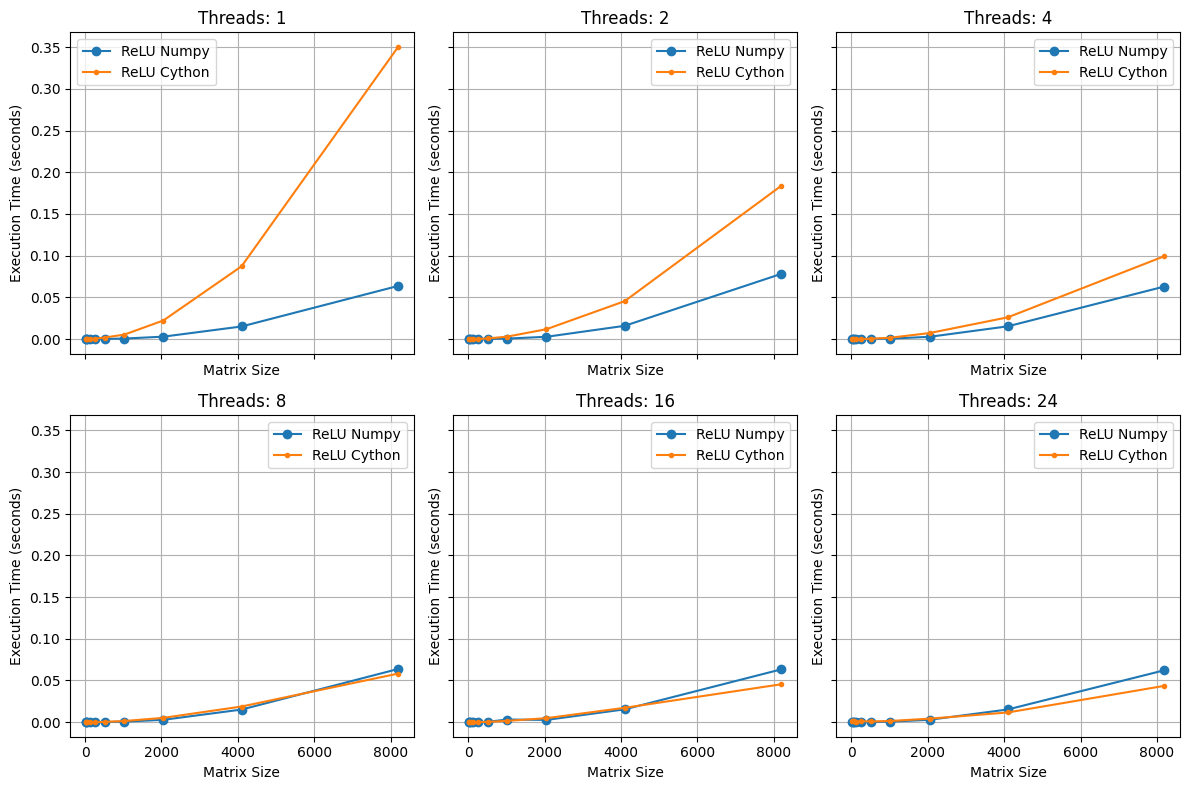

In [13]:
# Plotting subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

for i, n_threads in enumerate([1, 2, 4, 8, 16, 24]):
    row = i // 3
    col = i % 3
    axs[row, col].plot(sizes, relu_numpy_times[:, i], marker='o', label=f'ReLU Numpy')
    axs[row, col].plot(sizes, relu_cython_times[:, i], marker='.', label=f'ReLU Cython')
    axs[row, col].set_title(f'Threads: {n_threads}')
    axs[row, col].set_xlabel('Matrix Size')
    axs[row, col].set_ylabel('Execution Time (seconds)')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

Comments:

The Cython implementation outperforms numpy when threads start to increase, being barely equal at 8 threads and noticeably faster than numpy at 24 threads. However, at less than 8 threads numpy is faster.

# ReLU Activation: Backward Pass

To implement the backward pass for the ReLU activation function, open the file `sjk012/layers.py` and implement the `relu_backward` function.

### Backward Pass Formula:

The backward pass for the ReLU activation function involves computing the gradient with respect to the input \($X$\). The gradient is given by:

$$\nabla X = \nabla Y \cdot \text{mask}$$

Where $ \nabla Y $ is the upstream gradient and $ \text{mask} $ is a binary mask indicating which elements of the input were positive during the forward pass.

### Implementation:

1. **Gradient with Respect to Input**: Compute the gradient with respect to the input data \($\nabla X$\) using the formula above.

Once you complete the implementation of the `relu_backward` function, you can test its correctness using numeric gradient checking.

In [14]:
from sjk012.layers import relu_backward_numpy

np.random.seed(12)
x = np.random.randn(10, 10).astype(np.float32)
dy = np.random.randn(*x.shape).astype(np.float32)

dy_num = eval_numerical_gradient_array(lambda x: relu_forward_numpy(x)[0], x, dy, h=1e-3)

_, cache = relu_forward_numpy(x)
dy = relu_backward_numpy(dy, cache)

# The error should be on the order of e-5
print('Testing relu_backward function:')
print('dx error: ', rel_error(dy_num, dy))

Testing relu_backward function:
dx error:  3.6239555e-05


### ReLU Activation: Forward Pass with Cython:

To implement the backward pass for the ReLU activation function using Cython, follow these steps:

1. **Element-wise Operation**: Compute the gradient of the loss with respect to the input \($\nabla X$\) by multiplying the gradient of the loss with respect to the output of the ReLU layer by a binary mask. This mask should indicate which elements of the input were positive during the forward pass.

2. **Parallelization**: Utilize OpenMP parallelization to efficiently compute the backward pass operation across multiple threads.

Once you complete the implementation of the backward pass in `relu_bwd.pyx`, you need to compile the Cython module containing this function. You can compile it by executing the provided code or by running `python setup.py build_ext --inplace` in the previous directory.

In [13]:
%reload_ext autoreload
# Test the relu_backward function
from sjk012.layers import relu_backward_cython

import pyximport
pyximport.install(reload_support=True, pyimport=True)
from sjk012.relu_bwd.relu_bwd import relu_bwd_cython

np.random.seed(12)
x = np.random.randn(10, 10).astype(np.float32)
dy = np.random.randn(*x.shape).astype(np.float32)

dy_num = eval_numerical_gradient_array(lambda x: relu_forward_cython(x)[0], x, dy, h=1e-3)

_, cache = relu_forward_cython(x)
dy = relu_backward_cython(dy, cache)

# The error should be on the order of e-5
print('Testing relu_forward function:')
print('dx error: ', rel_error(dy_num, dy))

Testing relu_forward function:
dx error:  3.6239555e-05


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, fully-connected layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `sjk012/layer_utils.py`.

For now take a look at the `fc_relu_forward` and `fc_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [12]:
from sjk012.layer_utils import fc_relu_forward, fc_relu_backward

np.random.seed(12)
x = np.random.randn(2, 12).astype(np.float32)
w = np.random.randn(12, 10).astype(np.float32)
b = np.random.randn(10).astype(np.float32)
dy = np.random.randn(2, 10).astype(np.float32)

y, cache = fc_relu_forward(x, w, b)
dx, dw, db = fc_relu_backward(dy, cache)

dx_num = eval_numerical_gradient_array(lambda x: fc_relu_forward(x, w, b)[0], x, dy, h=1e-1)
dw_num = eval_numerical_gradient_array(lambda w: fc_relu_forward(x, w, b)[0], w, dy, h=1e-1)
db_num = eval_numerical_gradient_array(lambda b: fc_relu_forward(x, w, b)[0], b, dy, h=1e-2)

# Relative error should be around e-3 or less
print('Testing fc_relu_forward and fc_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing fc_relu_forward and fc_relu_backward:
dx error:  0.0003048242
dw error:  0.00010519987
db error:  2.5102025e-05


# Loss layers: Softmax
Now you have to implement the loss and gradient for the softmax in the `softmax_loss` function in `sjk012/layers.py`.

### Implementation
Follow these steps to implement the provided code:

1. **Compute the Softmax Probabilities**:

   The softmax probabilities $ P $ for each class $ i $ are computed as follows:

   $$ P_i = \frac{e^{x_i - \max(x)}}{\sum_{j} e^{x_j - \max(x)}} $$

   Where:
   - $ x $ is the input matrix of shape $(N, C)$ where $ N $ is the number of samples and $ C $ is the number of classes.
   - $ \max(x) $ computes the maximum value along each sample's row to improve numerical stability.

2. **Compute the Softmax Loss**:

   The softmax loss is calculated as the average cross-entropy loss over all samples:

   $$ \text{loss} = -\frac{1}{N}\sum_{i=1}^{N} \log(P_{i, y_i}) $$

   Where:
   - $ N $ is the number of samples.
   - $ y_i $ is the true label of sample $ i $.
   - $ P_{i, y_i} $ denotes the predicted probability of the true class for sample $ i $.

3. **Compute the Softmax Gradient**:

   The gradient of the softmax loss with respect to the input scores $ x $ is given by:

   $$ \frac{\partial L}{\partial x_i} = \frac{1}{N} (P_i - \text{one\_hot}(y_i)) $$

   Where:
   - $ P_i $ is the predicted probability of class $ i $.
   - $ \text{one\_hot}(y_i) $ is a one-hot encoded vector representing the true class of sample $ i $.
   - $ N $ is the number of samples, and dividing by $ N $ ensures averaging the gradients across all samples.
    
You can make sure that the implementations are correct by running the following:

In [8]:
from sjk012.layers import softmax_loss

np.random.seed(12)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes).astype(np.float32)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False, h=1e-1)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-3
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.3024002075195313
dx error:  0.0008681037


# Two-layer network
Open the file `sjk012/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [14]:
import numpy as np
from sjk012.fc_net import TwoLayerNet

np.random.seed(12)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D).astype(np.float32)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H).astype(np.float32)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H).astype(np.float32)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C).astype(np.float32)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C).astype(np.float32)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T.astype(np.float32)
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
print(scores_diff)
assert scores_diff < 1e-4, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
print(abs(loss - correct_loss))
assert abs(loss - correct_loss) < 1e-6, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
print(abs(loss - correct_loss))
assert abs(loss - correct_loss) < 1e-6, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-2)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
4.4409467772510425e-05
Testing training loss (no regularization)
2.929982749755311e-07
1.0232483660388425e-07
Running numeric gradient check with reg =  0.0
W1 relative error: 6.59e-03
W2 relative error: 3.00e-04
b1 relative error: 4.07e-03
b2 relative error: 1.36e-04
Running numeric gradient check with reg =  0.7
W1 relative error: 2.18e-01
W2 relative error: 2.00e-02
b1 relative error: 4.07e-03
b2 relative error: 1.36e-04


# Solver
Open the file `sjk012/solver.py` and read through it to familiarize yourself with the API. You also need to implement the `sgd` function in `sjk012/optim.py`. The Stochastic Gradient Descent (SGD) formula is:

$$W_{t+1} = W_t - \eta \cdot \nabla W$$

where:
- $W_t$ are the weights/biases at time step $t$,
- $\eta$ is the learning rate,
- $\nabla W_t$ is the gradient of the loss function with respect to weights/biases.

After implementing the SGD function, use a Solver instance to train a TwoLayerNet that achieves about 36% accuracy on the validation set.

In [15]:
from threadpoolctl import threadpool_limits

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 40% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=10, batch_size=100,
                print_every=100)
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.301117
(Epoch 0 / 10) train acc: 0.119000; val_acc: 0.114000
(Iteration 101 / 4900) loss: 1.842519
(Iteration 201 / 4900) loss: 1.720663
(Iteration 301 / 4900) loss: 1.600081
(Iteration 401 / 4900) loss: 1.606860
(Epoch 1 / 10) train acc: 0.442000; val_acc: 0.444000
(Iteration 501 / 4900) loss: 1.561455
(Iteration 601 / 4900) loss: 1.403225
(Iteration 701 / 4900) loss: 1.490684
(Iteration 801 / 4900) loss: 1.431790
(Iteration 901 / 4900) loss: 1.457075
(Epoch 2 / 10) train acc: 0.520000; val_acc: 0.450000
(Iteration 1001 / 4900) loss: 1.656115
(Iteration 1101 / 4900) loss: 1.571709
(Iteration 1201 / 4900) loss: 1.426333
(Iteration 1301 / 4900) loss: 1.693576
(Iteration 1401 / 4900) loss: 1.307174
(Epoch 3 / 10) train acc: 0.483000; val_acc: 0.469000
(Iteration 1501 / 4900) loss: 1.401825
(Iteration 1601 / 4900) loss: 1.352370
(Iteration 1701 / 4900) loss: 1.291957
(Iteration 1801 / 4900) loss: 1.493957
(Iteration 1901 / 4900) loss: 1.419986
(Epoch 4 / 10) t

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of more than 0.40 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

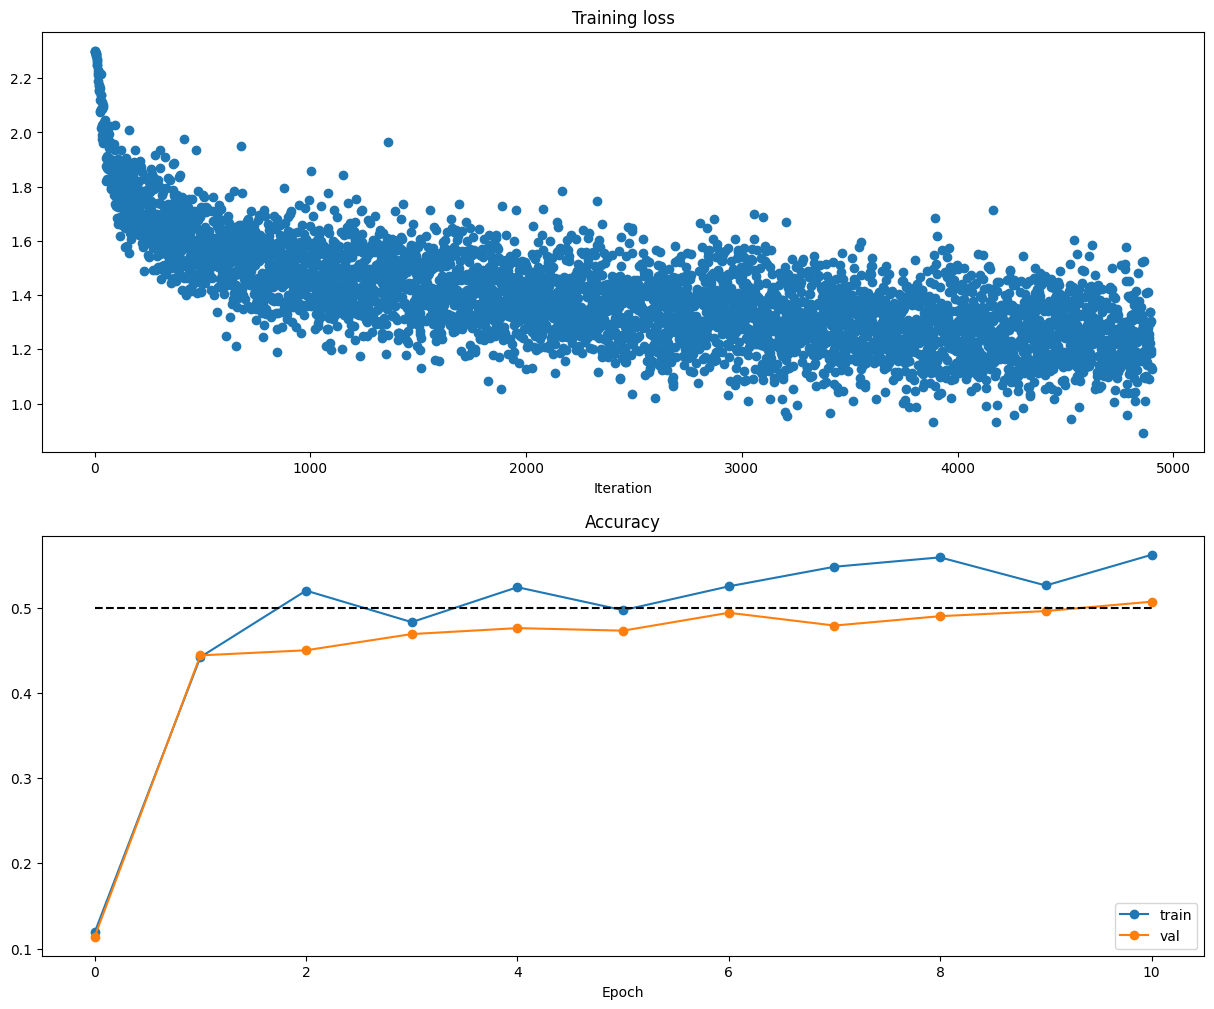

In [16]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

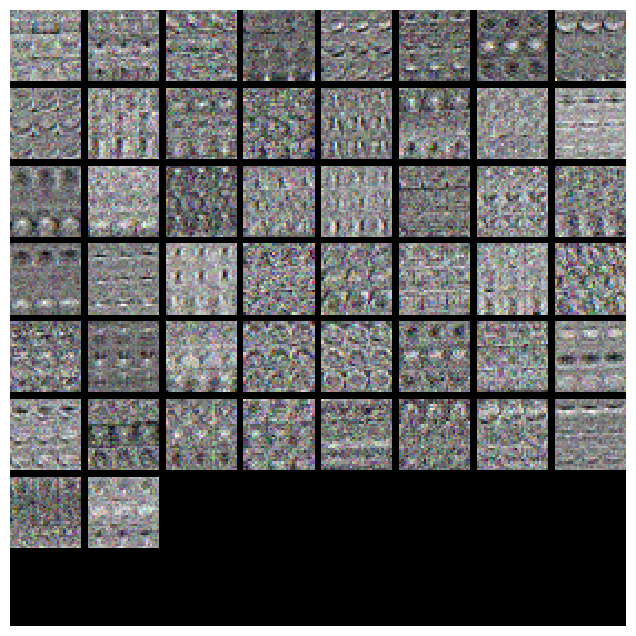

In [17]:
from sjk012.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

# Hyperparameter Tuning with Multi-threading

To expedite the hyperparameter search process, consider leveraging multiple threads to train your model. 

As indicated by the linear decrease in loss and lack of gap between training and validation accuracy, adjustments to hyperparameters such as learning rate, model size, batch size, and regularization strength may be necessary.

**Experimentation and Tuning**: Look a the hyperparameters including hidden layer size, learning rate, number of training epochs, batch size, and regularization strength. You may also explore tuning the learning rate decay, although satisfactory performance can often be achieved with the default value.

**Target Performance**: Aim for a classification accuracy exceeding 48% on the validation set, with the best networks achieving over 52%.

**Goal**: Your objective is to achieve optimal performance on CIFAR-10 with a fully-connected Neural Network. Use experimentation and hyperparameter tuning to iteratively refine your model's performance.


In [17]:
best_model = None
best_val = -1

results = {}


learning_rates = np.geomspace(3e-4, 3e-2, 3)
regularization_strengths = np.geomspace(1e-6, 1e-2, 5)

import itertools

#################################################################################
# TODO: Parallelise the hyperparmeter search procedure                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

with threadpool_limits(limits=16):

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    for lr, reg in itertools.product(learning_rates, regularization_strengths):
        # Create Two Layer Net and train it with Solver
        model = TwoLayerNet(hidden_dim=128, reg=reg)
        solver = Solver(model, data, optim_config={'learning_rate': lr}, num_epochs=10, verbose=False)
        solver.train()
    
        # Compute validation set accuracy and append to the dictionary
        results[(lr, reg)] = solver.best_val_acc

        # Save if validation accuracy is the best
        if results[(lr, reg)] > best_val:
            best_val = results[(lr, reg)]
            best_model = model

# Print out results.
for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

/home/pabloju/HPML/assignment1/sjk012/layers.py:235: RuntimeWarning: overflow encountered in subtract
  x = np.clip(x, -700, 700)  # Prevent overflow
/home/pabloju/HPML/assignment1/sjk012/layers.py:235: RuntimeWarning: invalid value encountered in subtract
  x = np.clip(x, -700, 700)  # Prevent overflow
/home/pabloju/miniconda3/envs/hpml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


lr 3.000000e-04 reg 1.000000e-06 val accuracy: 0.517000
lr 3.000000e-04 reg 1.000000e-05 val accuracy: 0.512000
lr 3.000000e-04 reg 1.000000e-04 val accuracy: 0.529000
lr 3.000000e-04 reg 1.000000e-03 val accuracy: 0.515000
lr 3.000000e-04 reg 1.000000e-02 val accuracy: 0.519000
lr 3.000000e-03 reg 1.000000e-06 val accuracy: 0.328000
lr 3.000000e-03 reg 1.000000e-05 val accuracy: 0.191000
lr 3.000000e-03 reg 1.000000e-04 val accuracy: 0.344000
lr 3.000000e-03 reg 1.000000e-03 val accuracy: 0.155000
lr 3.000000e-03 reg 1.000000e-02 val accuracy: 0.346000
lr 3.000000e-02 reg 1.000000e-06 val accuracy: 0.146000
lr 3.000000e-02 reg 1.000000e-05 val accuracy: 0.124000
lr 3.000000e-02 reg 1.000000e-04 val accuracy: 0.145000
lr 3.000000e-02 reg 1.000000e-03 val accuracy: 0.102000
lr 3.000000e-02 reg 1.000000e-02 val accuracy: 0.163000
best validation accuracy achieved during cross-validation: 0.529000


In [11]:
'''
# Alternative approach that takes half time using ThreadPoolExecutor
import concurrent.futures
import itertools

best_model = None
best_val = -1

results = {}


learning_rates = np.geomspace(3e-4, 3e-2, 3)
regularization_strengths = np.geomspace(1e-6, 1e-2, 5)

#################################################################################
# TODO: Parallelise the hyperparmeter search procedure                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Create a function to train the model and return the model and validation accuracy
def train_model(lr, reg):
    # Create Two Layer Net and train it with Solver
    model = TwoLayerNet(hidden_dim=128, reg=reg)
    solver = Solver(model, data, optim_config={'learning_rate': lr}, num_epochs=10, verbose=False)
    solver.train()

    # Return the model and validation accuracy
    return model, solver.best_val_acc

# Create a list to store the results
results = []

# Create a ThreadPoolExecutor with the desired number of threads
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to submit the training tasks
    futures = [executor.submit(train_model, lr, reg) for lr, reg in itertools.product(learning_rates, regularization_strengths)]

    # Retrieve the results as they become available
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        results.append(result)

# Print out results.
for (lr, reg), (model, val_accuracy) in zip(itertools.product(learning_rates, regularization_strengths), results):
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))

# Find the best validation accuracy and corresponding model
best_model, best_val = max(results, key=lambda x: x[1])
best_index = results.index((best_model, best_val))
product_list = list(itertools.product(learning_rates, regularization_strengths))
best_lr, best_reg = product_list[best_index]

print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('best learning rate: %e' % best_lr)
print('best regularization strength: %e' % best_reg)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
'''

/home/pabloju/HPML/assignment1/sjk012/layers.py:234: RuntimeWarning: overflow encountered in subtract
  x = x - np.max(x, axis=1, keepdims=True)  # For numerical stability
/home/pabloju/HPML/assignment1/sjk012/layers.py:234: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=1, keepdims=True)  # For numerical stability


lr 3.000000e-04 reg 1.000000e-06 val accuracy: 0.392000
lr 3.000000e-04 reg 1.000000e-05 val accuracy: 0.165000
lr 3.000000e-04 reg 1.000000e-04 val accuracy: 0.123000
lr 3.000000e-04 reg 1.000000e-03 val accuracy: 0.163000
lr 3.000000e-04 reg 1.000000e-02 val accuracy: 0.534000
lr 3.000000e-03 reg 1.000000e-06 val accuracy: 0.525000
lr 3.000000e-03 reg 1.000000e-05 val accuracy: 0.182000
lr 3.000000e-03 reg 1.000000e-04 val accuracy: 0.366000
lr 3.000000e-03 reg 1.000000e-03 val accuracy: 0.119000
lr 3.000000e-03 reg 1.000000e-02 val accuracy: 0.182000
lr 3.000000e-02 reg 1.000000e-06 val accuracy: 0.528000
lr 3.000000e-02 reg 1.000000e-05 val accuracy: 0.285000
lr 3.000000e-02 reg 1.000000e-04 val accuracy: 0.534000
lr 3.000000e-02 reg 1.000000e-03 val accuracy: 0.171000
lr 3.000000e-02 reg 1.000000e-02 val accuracy: 0.529000
best validation accuracy achieved during cross-validation: 0.534000
best learning rate: 3.000000e-04
best regularization strength: 1.000000e-02


# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [18]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.529


In [19]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.521
